In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from itertools import product
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

import datetime


In [2]:
data = pd.read_csv("startupData/ks-projects-201801.csv")
df= data.copy()
print(df.head())

           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15

## Potential things to do after:

-using the category feature instead of main_category somehow (merging the one that is very small in number but keep the one that is relatively large!)

-country variable & currency DONE

-outliers are a huge part of this dataset

-Hi, has anyone noticed that in the database ks-projects-201801 there are 105 successful projects with zero backers? Is there a possible error in the database or am I missing something? Not helping much here, but those rows also have N,0" as country. It seems to be an error with the web scraping used to obtain the data. In fact I googled the project Jackson Ruby: The Cassette Album and it had 36 backers

Website references:
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

-alter more of the decision trees hyperparameters


## Descriptive statistics (+some preprocessing)

In [3]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [4]:
print(df.shape)
df.describe()


(378661, 15)


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [5]:
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [3]:
df1 = df.copy()
df = df.drop(columns = ['pledged','goal','usd pledged'])
df = df.dropna()
df.shape

(378657, 12)

In [7]:
df['name'].unique()

array(['The Songs of Adelaide & Abullah',
       'Greeting From Earth: ZGAC Arts Capsule For ET', 'Where is Hank?',
       ...,
       'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!',
       'BioDefense Education Kit', 'Nou Renmen Ayiti!  We Love Haiti!'],
      dtype=object)

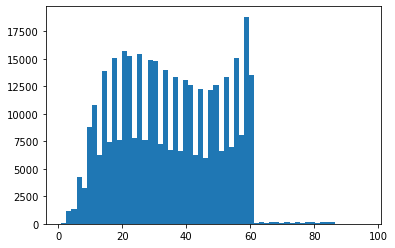

In [4]:
df['nameLength'] = df['name'].str.len()
plt.hist(df['nameLength'], bins=60)
plt.show()

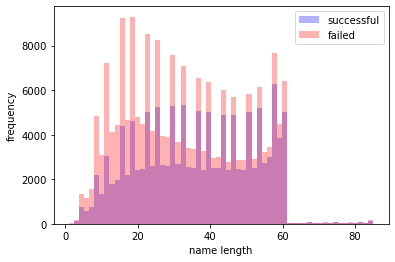

In [33]:
plt.hist(df['nameLength'][df['state']=="successful"],color='b', alpha = 0.3, bins=60, label='successful')
plt.hist(df['nameLength'][df['state']=="failed"],color='r', alpha = 0.3, bins=60, label='failed')
plt.xlabel('name length')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [6]:
df['category'].value_counts()

Product Design     22313
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [8]:
df['main_category'].value_counts()

Film & Video    63584
Music           51918
Publishing      39874
Games           35230
Technology      32569
Design          30069
Art             28152
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64

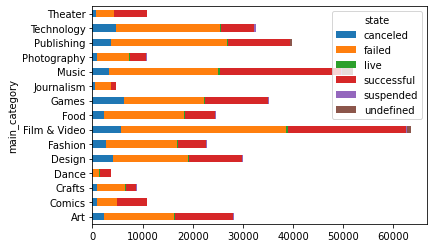

In [9]:
df.groupby(['main_category','state']) \
                        .size() \
                        .groupby(level=0) \
                        .apply(lambda x: x) \
                        .to_frame(name = 'percentage') \
                        .reset_index() \
                        .pivot(index='main_category',columns='state',values='percentage') \
                        .reset_index() \
                        .set_index('main_category') \
                        .plot.barh(stacked=True)

In [10]:
#I want to know each categories, how many each and maybe we can have a better way 
#to use this category instead of main_category



In [11]:
#both currency and country might be highly correlated
df['currency'].value_counts()

USD    295362
GBP     34131
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

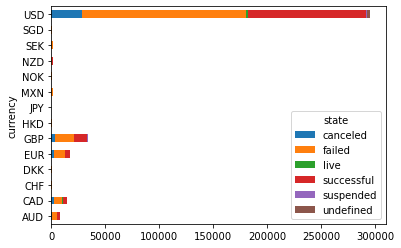

In [12]:
df.groupby(['currency','state']) \
                        .size() \
                        .groupby(level=0) \
                        .apply(lambda x: x) \
                        .to_frame(name = 'percentage') \
                        .reset_index() \
                        .pivot(index='currency',columns='state',values='percentage') \
                        .reset_index() \
                        .set_index('currency') \
                        .plot.barh(stacked=True)

Very tempted to group the one that cannot be seen in the above graph into "other" category

In [5]:
df['currency'].replace({'USD':'USD',
 'GBP':'GBP',
 'EUR':'EUR',
 'CAD':'CAD',
 'AUD':'AUD',
 'SEK':'other',
 'MXN':'other',
 'NZD':'other',
 'DKK':'other',
 'CHF':'other',
 'NOK':'other',
 'HKD':'other',
 'SGD':'other',
 'JPY':'other'}, inplace=True)

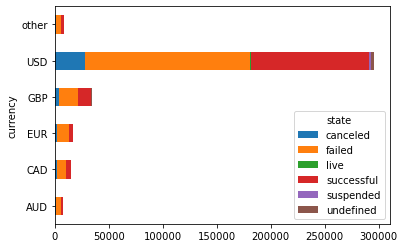

In [7]:
df.groupby(['currency','state']) \
                        .size() \
                        .groupby(level=0) \
                        .apply(lambda x: x) \
                        .to_frame(name = 'percentage') \
                        .reset_index() \
                        .pivot(index='currency',columns='state',values='percentage') \
                        .reset_index() \
                        .set_index('currency') \
                        .plot.barh(stacked=True)

In [15]:
df['country'].value_counts()

US      292624
GB       33671
CA       14756
AU        7839
DE        4171
N,0"      3797
FR        2939
IT        2878
NL        2868
ES        2276
SE        1757
MX        1752
NZ        1447
DK        1113
IE         811
CH         761
NO         708
HK         618
BE         617
AT         597
SG         555
LU          62
JP          40
Name: country, dtype: int64

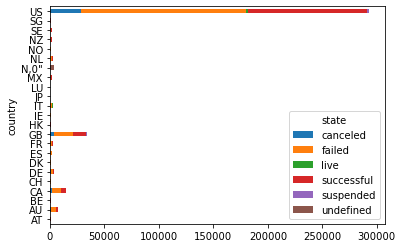

In [16]:
df.groupby(['country','state']) \
                        .size() \
                        .groupby(level=0) \
                        .apply(lambda x: x) \
                        .to_frame(name = 'percentage') \
                        .reset_index() \
                        .pivot(index='country',columns='state',values='percentage') \
                        .reset_index() \
                        .set_index('country') \
                        .plot.barh(stacked=True)

Again, tempted to group the "hard to see" one into "other" category; however, currency should be alone enough since they are very similar. Furthermore, for country, if you group all EUROPEAN together, you will have the exact same category as the currency. Therefore, not need for this

In [17]:
df['backers'].describe()

count    378657.000000
mean        105.618544
std         907.189767
min           0.000000
25%           2.000000
50%          12.000000
75%          56.000000
max      219382.000000
Name: backers, dtype: float64

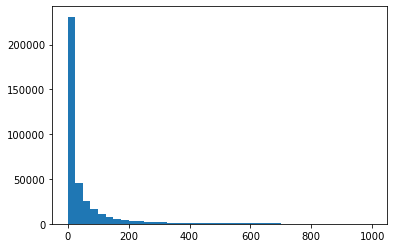

In [18]:
plt.hist(df['backers'][df['backers']<1000],bins=40)
plt.show()

In [19]:
df['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

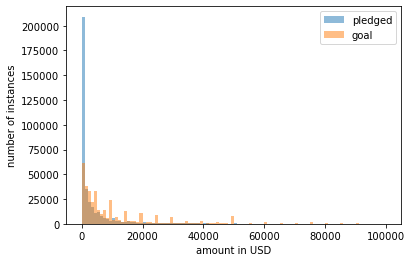

In [8]:
#have to zoom in since the default limit on axis is atrocious
plt.hist(df['usd_pledged_real'][df['usd_pledged_real']<100000],label='pledged',alpha = 0.5,bins=100)
plt.hist(df['usd_goal_real'][df['usd_goal_real']<100000],label='goal',alpha = 0.5,bins=100)
plt.xlabel("amount in USD")
plt.ylabel("number of instances")
plt.legend()
plt.show()

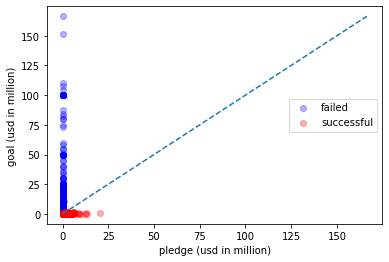

In [9]:
#graph to see if there is any strange observation, also this is usd in million
plt.scatter(df['usd_pledged_real'][df['state']=="failed"]/10**6,df['usd_goal_real'][df['state']=="failed"]/10**6,c='b', alpha = 0.3, label='failed')
plt.scatter(df['usd_pledged_real'][df['state']=="successful"]/10**6,df['usd_goal_real'][df['state']=="successful"]/10**6,c='r', alpha = 0.3, label='successful')
plt.plot(np.linspace(min(df['usd_goal_real'])/10**6,max(df['usd_goal_real']))/10**6,np.linspace(min(df['usd_goal_real'])/10**6,max(df['usd_goal_real']))/10**6,'--')
plt.xlabel('pledge (usd in million)')
plt.ylabel('goal (usd in million)')
plt.legend(loc='center right')
plt.show()

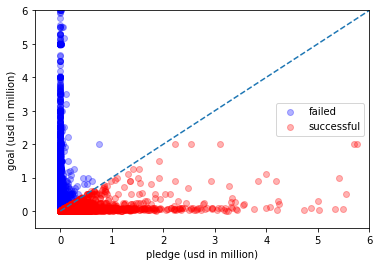

In [22]:
#zoom in 
plt.scatter(df['usd_pledged_real'][df['state']=="failed"]/10**6,df['usd_goal_real'][df['state']=="failed"]/10**6,c='b', alpha = 0.3, label='failed')
plt.scatter(df['usd_pledged_real'][df['state']=="successful"]/10**6,df['usd_goal_real'][df['state']=="successful"]/10**6,c='r', alpha = 0.3, label='successful')
plt.plot(np.linspace(min(df['usd_goal_real'])/10**6,max(df['usd_goal_real']))/10**6,np.linspace(min(df['usd_goal_real'])/10**6,max(df['usd_goal_real']))/10**6,'--')
plt.xlim(-0.5, 6)
plt.ylim(-0.5, 6)
plt.xlabel('pledge (usd in million)')
plt.ylabel('goal (usd in million)')
plt.legend(loc='center right')
plt.show()


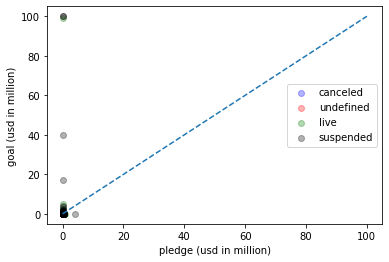

In [23]:
plt.scatter(df['usd_pledged_real'][df['state']=="canceled "]/10**6,df['usd_goal_real'][df['state']=="canceled "]/10**6,c='b', alpha = 0.3, label='canceled')
plt.scatter(df['usd_pledged_real'][df['state']=="undefined"]/10**6,df['usd_goal_real'][df['state']=="undefined"]/10**6,c='r', alpha = 0.3, label='undefined')
plt.scatter(df['usd_pledged_real'][df['state']=="live"]/10**6,df['usd_goal_real'][df['state']=="live"]/10**6,c='g', alpha = 0.3, label='live')
plt.scatter(df['usd_pledged_real'][df['state']=="suspended"]/10**6,df['usd_goal_real'][df['state']=="suspended"]/10**6,c='k', alpha = 0.3, label='suspended')
plt.plot(np.linspace(min(df['usd_goal_real'][df['state']=="suspended"])/10**6,max(df['usd_goal_real'][df['state']=="suspended"]))/10**6,np.linspace(min(df['usd_goal_real'][df['state']=="suspended"])/10**6,max(df['usd_goal_real'][df['state']=="suspended"]))/10**6,'--')
plt.xlabel('pledge (usd in million)')
plt.ylabel('goal (usd in million)')
plt.legend(loc='center right')
plt.show()

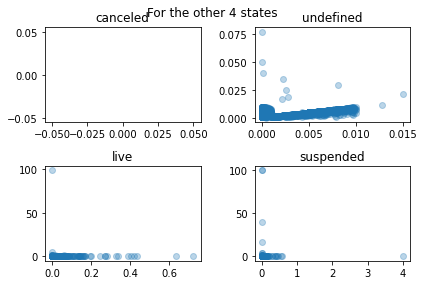

In [42]:
fig, ax = plt.subplots(2, 2)
fig.suptitle('For the other 4 states')
# gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
# (ax[0,0], ax[0,1]), (ax[1,0], ax[1,1]) = gs.subplots(sharex='col', sharey='row')

ax[0,0].scatter(df['usd_pledged_real'][df['state']=="canceled "]/10**6,df['usd_goal_real'][df['state']=="canceled "]/10**6, alpha = 0.3)
ax[0,0].set_title('canceled')

ax[0,1].scatter(df['usd_pledged_real'][df['state']=="undefined"]/10**6,df['usd_goal_real'][df['state']=="undefined"]/10**6, alpha = 0.3)
ax[0,1].set_title('undefined')

ax[1,0].scatter(df['usd_pledged_real'][df['state']=="live"]/10**6,df['usd_goal_real'][df['state']=="live"]/10**6, alpha = 0.3)
ax[1,0].set_title('live')

ax[1,1].scatter(df['usd_pledged_real'][df['state']=="suspended"]/10**6,df['usd_goal_real'][df['state']=="suspended"]/10**6, alpha =0.3)
ax[1,1].set_title('suspended')
fig.tight_layout()


In [48]:
print(df['usd_pledged_real'][df['state']=="canceled "].value_counts())
print(df['usd_goal_real'][df['state']=="canceled "].value_counts())



Series([], Name: usd_pledged_real, dtype: int64)
Series([], Name: usd_goal_real, dtype: int64)


In [6]:
#date and time data to float for easier regression
df['launched']=pd.to_datetime(df['launched']).dt.date
df['launchTime'] = (df['launched'] - df['launched'].min())  / np.timedelta64(1,'D')
df['launchTime'].describe()

count    378657.000000
mean      16341.194160
std         705.965213
min           0.000000
25%       15832.000000
50%       16414.000000
75%       16884.000000
max       17533.000000
Name: launchTime, dtype: float64

In [7]:
#note that the time base is on the launch date to get a relative length relationship of the project as well
df['deadlineDum']=pd.to_datetime(df['deadline']).dt.date
df['deadlineTime'] = (df['deadlineDum'] - df['launched'].min())  / np.timedelta64(1,'D')
df['deadlineTime'].describe()

count    378657.000000
mean      16375.675260
std         700.510104
min       14367.000000
25%       15864.000000
50%       16449.000000
75%       16919.000000
max       17593.000000
Name: deadlineTime, dtype: float64

count    378657.000000
mean         34.481100
std          65.909503
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max       16739.000000
Name: projectLength, dtype: float64


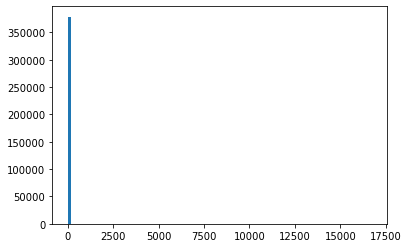

In [8]:
#Project length and histogram: most of the outlier coming from the other 4 categories
df['projectLength'] = df['deadlineTime'] - df['launchTime'] 
print(df['projectLength'].describe())
plt.hist(df['projectLength'],bins=100)
plt.show()

In [9]:
print(df[['projectLength','state']].groupby('state').max())
print(df[['projectLength','state']].groupby('state').min())
print(df[['projectLength','state']].groupby('state').mean())

            projectLength
state                    
canceled          14867.0
failed               92.0
live                 61.0
successful           92.0
suspended         16739.0
undefined            90.0
            projectLength
state                    
canceled              1.0
failed                1.0
live                  4.0
successful            1.0
suspended             1.0
undefined             2.0
            projectLength
state                    
canceled        38.269089
failed          35.173319
live            39.805288
successful      32.156447
suspended       44.484011
undefined       32.877035


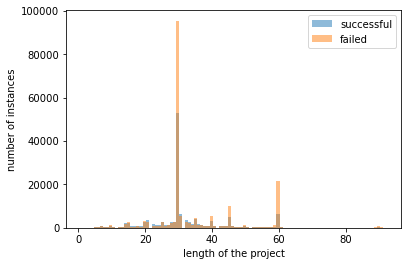

In [10]:
plt.hist(df['projectLength'][df['state']=='successful'], label='successful',alpha = 0.5,bins=100)
plt.hist(df['projectLength'][df['state']=='failed'], label='failed',alpha = 0.5,bins=100)
plt.xlabel("length of the project")
plt.ylabel("number of instances")
plt.legend()
plt.show()

## Training time! 

The problem can be seen in 2 ways (thus, 2 dependent variables):

-The problem concerning only if the project is successful or not (~external margin). Here the pledged is assumed to be "unknown" (otherwise, there is no point doing prediction and regression when you already know the pledge amount at the deadline). The dependent variable here is successful or failed

-The problem concerning how successful (or failed) the project is basing on the amount of pledged they have gotten at the deadline. The dependent variable here is usd_pledged_real


In [30]:
#choose variables:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'backers', 'country', 'usd_pledged_real',
       'usd_goal_real', 'nameLength', 'launchTime', 'deadlineDum',
       'deadlineTime', 'projectLength'],
      dtype='object')

In [11]:
# deep copy datasets, keeping dfOri unchanged
dfOri = df.copy()
df = dfOri.copy()
df = df.drop(columns = ['ID','deadline','launched','deadlineDum'],errors='ignore' )
df.columns

Index(['name', 'category', 'main_category', 'currency', 'state', 'backers',
       'country', 'usd_pledged_real', 'usd_goal_real', 'nameLength',
       'launchTime', 'deadlineTime', 'projectLength'],
      dtype='object')

In [12]:
# train test split
df_rest, df_test = train_test_split(df,test_size=0.1, random_state=123)
df_train, df_val = train_test_split(df_rest, test_size=0.2, random_state=123)
print(df_rest.shape)
print(df_test.shape)
print(df_train.shape)
print(df_val.shape)
df_train.columns

(340791, 13)
(37866, 13)
(272632, 13)
(68159, 13)


Index(['name', 'category', 'main_category', 'currency', 'state', 'backers',
       'country', 'usd_pledged_real', 'usd_goal_real', 'nameLength',
       'launchTime', 'deadlineTime', 'projectLength'],
      dtype='object')

### Dependent variable = state (here we only care about successful and failed, dropping the other four categories)

In [13]:
#df1 has all the thing needed for this part
dfS_train = df_train.copy()
dfS_train = dfS_train[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_train = dfS_train[(dfS_train['state'] == 'successful') | (dfS_train['state'] == 'failed')]
dfS_train.shape


(238755, 10)

In [14]:
dfS_val = df_val.copy()
dfS_val = dfS_val[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_val = dfS_val[(dfS_val['state'] == 'successful') | (dfS_val['state'] == 'failed')]
dfS_val.shape


(59670, 10)

In [15]:
# Category
mainCategory = dfS_train['main_category'].value_counts().keys().to_list()
print(mainCategory)
currency = dfS_train['currency'].value_counts().keys().to_list()
print(currency)

['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Art', 'Design', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography', 'Crafts', 'Journalism', 'Dance']
['USD', 'GBP', 'EUR', 'CAD', 'other', 'AUD']


#### Only have numerical features (excluding the "name" feature)


In [16]:
X_train1 = dfS_train.drop(columns=['state','name'])
y_train1 = dfS_train['state']
X_val1 = dfS_val.drop(columns=['state','name'])
y_val1 = dfS_val['state']

enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')

prepro1 = make_column_transformer((enc1, ['main_category','currency']),
                                      (StandardScaler(), ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']))
#see if it is working
print(prepro1.fit_transform(X_train1).toarray()[0])


[ 0.          0.          0.          0.          0.          0.
  0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.
  0.         -0.12028046 -0.03699813 -1.76990372  0.51490314  0.51083313
 -0.31077187]


In [19]:
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200))

model1.fit(X_train1, y_train1)

predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 88.11752633452703 %
The accuracy of the model in validation set: 87.86492374727669 %


at 200 max_iter, the model converges. No need to hypertune max_iter. Default tolerance is also good

Now we start to hypertune some other parameters

Just realize that if you have already achieve convergence, there is not need to find other solvers for the same penalty and c_values

In [42]:
#Simple hypertune
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2','l1']
c_values = [100, 10, 1.0, 0.1,0.01]
#running all specification and comparing their validation accuracy
results = np.zeros((40,2))
i = 0
for sol in solvers:
    for c in c_values:
        for pen in penalty:
            if pen == 'l1':
                if (sol == 'liblinear') | (sol == 'saga'):
                    begin = time.time()
                    logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=200)
                    model = make_pipeline(prepro1, logic)
                    model.fit(X_train1, y_train1)
                    results[i,0] = model.score(X_val1,y_val1)
                    results[i,1] = model.score(X_train1,y_train1)
                    i +=1
                    end = time.time()
                    print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
                    break
                else:
                    print(f'specification of {sol} and {pen} is not supported')
                    break
            begin = time.time()
            logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=200)
            model = make_pipeline(prepro1, logic)
            model.fit(X_train1, y_train1)
            results[i,0] = model.score(X_val1,y_val1)
            results[i,1] = model.score(X_train1,y_train1)
            i+=1
            end = time.time()
            print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
        

index for sovler newton-cg,c value 100 and pennalty l2 is 1, run time 7.530087947845459
specification of newton-cg and l1 is not supported
index for sovler newton-cg,c value 10 and pennalty l2 is 2, run time 6.8673200607299805
specification of newton-cg and l1 is not supported
index for sovler newton-cg,c value 1.0 and pennalty l2 is 3, run time 5.488463878631592
specification of newton-cg and l1 is not supported
index for sovler newton-cg,c value 0.1 and pennalty l2 is 4, run time 5.770832777023315
specification of newton-cg and l1 is not supported
index for sovler newton-cg,c value 0.01 and pennalty l2 is 5, run time 4.864330291748047
specification of newton-cg and l1 is not supported
index for sovler lbfgs,c value 100 and pennalty l2 is 6, run time 5.231847047805786
specification of lbfgs and l1 is not supported
index for sovler lbfgs,c value 10 and pennalty l2 is 7, run time 6.282382965087891
specification of lbfgs and l1 is not supported
index for sovler lbfgs,c value 1.0 and penn

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 100 and pennalty l1 is 12, run time 1685.9324407577515
index for sovler liblinear,c value 10 and pennalty l2 is 13, run time 5.628790616989136


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 10 and pennalty l1 is 14, run time 1716.9928178787231
index for sovler liblinear,c value 1.0 and pennalty l2 is 15, run time 4.844170093536377


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 1.0 and pennalty l1 is 16, run time 34.14503026008606
index for sovler liblinear,c value 0.1 and pennalty l2 is 17, run time 3.651193141937256


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 0.1 and pennalty l1 is 18, run time 33.60725474357605
index for sovler liblinear,c value 0.01 and pennalty l2 is 19, run time 2.933659315109253


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 0.01 and pennalty l1 is 20, run time 35.891732931137085


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 100 and pennalty l2 is 21, run time 27.43785786628723
specification of sag and l1 is not supported


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 10 and pennalty l2 is 22, run time 27.285377979278564
specification of sag and l1 is not supported


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 1.0 and pennalty l2 is 23, run time 26.97067093849182
specification of sag and l1 is not supported


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.1 and pennalty l2 is 24, run time 27.773160934448242
specification of sag and l1 is not supported


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.01 and pennalty l2 is 25, run time 27.462941884994507
specification of sag and l1 is not supported


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 100 and pennalty l2 is 26, run time 27.851332902908325


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 100 and pennalty l1 is 27, run time 34.99182105064392


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 10 and pennalty l2 is 28, run time 27.36539602279663


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 10 and pennalty l1 is 29, run time 34.78453516960144


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 1.0 and pennalty l2 is 30, run time 28.18704605102539


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 1.0 and pennalty l1 is 31, run time 34.72691512107849


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.1 and pennalty l2 is 32, run time 28.211566925048828


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.1 and pennalty l1 is 33, run time 34.33802795410156


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.01 and pennalty l2 is 34, run time 28.11513900756836


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.01 and pennalty l1 is 35, run time 31.80356001853943


In [63]:

print(np.concatenate((np.arange(1,41).reshape(40,1), results),axis=1))

[[ 1.          0.90429026  0.90671609]
 [ 2.          0.89986593  0.90203765]
 [ 3.          0.87868276  0.88117107]
 [ 4.          0.84385789  0.84628175]
 [ 5.          0.80186023  0.8040795 ]
 [ 6.          0.90430702  0.90673284]
 [ 7.          0.89988269  0.90203347]
 [ 8.          0.87864924  0.88117526]
 [ 9.          0.84385789  0.84626081]
 [10.          0.80186023  0.80408787]
 [11.          0.90425675  0.90670771]
 [12.          0.73425507  0.73546104]
 [13.          0.89986593  0.90202928]
 [14.          0.73750628  0.7380746 ]
 [15.          0.87868276  0.88117107]
 [16.          0.71908832  0.72135034]
 [17.          0.84379085  0.84623149]
 [18.          0.71950729  0.72142573]
 [19.          0.80174292  0.80387008]
 [20.          0.72287582  0.72532094]
 [21.          0.81342383  0.81561014]
 [22.          0.81344059  0.8155892 ]
 [23.          0.81313893  0.8154091 ]
 [24.          0.81121166  0.8136416 ]
 [25.          0.79460365  0.79605872]
 [26.          0.79963131

liblinear with l1 took too much time and converges much slower ==> not worth running

Other options


In [48]:
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200,penalty = 'none'))

model1.fit(X_train1, y_train1)

predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 90.7369479173211 %
The accuracy of the model in validation set: 90.50779286073404 %


In [64]:
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=500,solver = 'saga', penalty = 'l1'))

model1.fit(X_train1, y_train1)

predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


The accuracy of the model in training set: 82.06320286486147 %
The accuracy of the model in validation set: 81.9222389810625 %


In [ ]:
# #Super hypertuning, will take lots of time leave it last
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model1, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train1, y_train1)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [17]:
#pick model
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200,penalty = 'none'))
begin = time.time()
model1.fit(X_train1, y_train1)
print(f'time taken to run {time.time()-begin}')
predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

time taken to run 7.533486843109131
The accuracy of the model in training set: 90.7369479173211 %
The accuracy of the model in validation set: 90.50779286073404 %


In [18]:
print(model1[1].coef_)
print(model1[1].intercept_)


[[-1.07176273e-01 -7.86558024e-01 -1.75724925e+00 -8.61977590e-01
  -2.41169292e-01 -8.77954180e-01 -6.73182459e-01 -8.36656686e-01
   4.44779927e-01 -7.19443325e-01 -6.36745745e-01 -9.33666955e-01
  -8.65574560e-01  4.59204842e-01  7.59308991e-02 -1.43271998e-01
  -1.38797592e-01 -3.82021519e-02 -2.49164137e-01  5.25683315e+01
  -2.51182687e+02  1.07714782e-01 -1.71568454e-02 -2.01644300e-02
  -1.62836187e-01]]
[-3.57958722]


In [154]:
enc11 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first',sparse = False)

prepro11 = make_column_transformer((enc11, ['main_category','currency']),
                                      (StandardScaler(), ['backers','usd_goal_real', 'nameLength', 'launchTime', 'projectLength']))

X_trainlogit = prepro11.fit_transform(X_train1.drop(columns= ['deadlineTime']))
# X_vallogit = prepro1.fit_transform(X_val1)

dum = enc1.fit_transform(X_train1[['main_category','currency']])
listFeat = enc1.get_feature_names(['main_category','currency']).tolist()
listContFeat = ['backers','usd_goal_real', 'nameLength', 'launchTime', 'projectLength']
for i in listContFeat:
    listFeat.append(i)

X_trainlogit = pd.DataFrame(X_trainlogit, columns=listFeat)  
X_trainlogit = sm.add_constant(X_trainlogit)

# X_vallogit = pd.DataFrame(X_vallogit, columns=listFeat)  
# X_vallogit = sm.add_constant(X_vallogit)

y_trainlogit = y_train1.replace(['successful','failed'],[1.0,0.0])
y_trainlogit = list(y_trainlogit)

logitReg = sm.Logit(y_trainlogit, X_trainlogit).fit()
print(logitReg.summary())

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.315606
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               238755
Model:                          Logit   Df Residuals:                   238730
Method:                           MLE   Df Model:                           24
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                  0.5321
Time:                        18:12:18   Log-Likelihood:                -75352.
converged:                       True   LL-Null:                   -1.6106e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -3.5724      0.043    -83.089      0.000      -3

#### Have extra text features (preprocessing the "name" feature)

In [19]:
X_train2 = dfS_train.drop(columns=['state'])
y_train2 = dfS_train['state']
X_val2 = dfS_val.drop(columns=['state'])
y_val2 = dfS_val['state']

textPrep = make_pipeline(CountVectorizer(lowercase=True),TfidfTransformer())
enc2 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')

prepro2 = make_column_transformer((textPrep,'name'),
    (enc2, ['main_category','currency']),
    (StandardScaler(), ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']))
#see if it is working
dum = prepro2.fit_transform(X_train2).toarray()
print(dum[0])
print(dum.shape)

[ 0.          0.          0.         ...  0.51490314  0.51083313
 -0.31077187]
(238755, 108324)


In [18]:
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=700))

model2.fit(X_train2, y_train2)

predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 90.20418420556638 %
The accuracy of the model in validation set: 87.5330987095693 %


In [75]:
max_iter = [1,5,10,100,200,300,400,500,800,1000]

results2 = np.zeros((len(max_iter),2))
converg = np.zeros((len(max_iter)))
for i in range(len(max_iter)):
    model = make_pipeline(prepro2, LogisticRegression(max_iter=max_iter[i]))
    model.fit(X_train2, y_train2)

    results2[i,0] = model.score(X_val2,y_val2)
    results2[i,1] = model.score(X_train2,y_train2)
    converg[i] = model[1].n_iter_
    print(f'validation score for max iter = {max_iter[i]} is {results2[i,0]}')


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 1 is 0.6226411932294286


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 5 is 0.7177811295458354


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 10 is 0.7937321937321937


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 100 is 0.8739735210323446


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 200 is 0.8781297134238311


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 300 is 0.8752471928942517


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 400 is 0.8746438746438746


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 500 is 0.875330987095693
validation score for max iter = 800 is 0.875330987095693
validation score for max iter = 1000 is 0.875330987095693


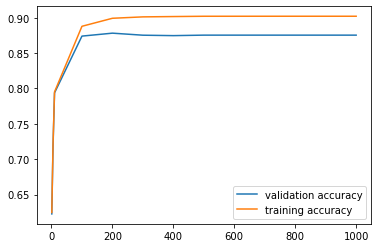

In [76]:
plt.plot(max_iter, results2[:,0], label = 'validation accuracy')
plt.plot(max_iter, results2[:,1], label = 'training accuracy')
plt.legend()
plt.show()

In [57]:
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=700,penalty='none'))
begin = time.time()
model2.fit(X_train2, y_train2)
print(f'time run is {time.time()-begin}')
predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time run is 45.18294310569763
The accuracy of the model in training set: 94.86754204100438 %
The accuracy of the model in validation set: 85.63599798893917 %


In [59]:
#Simple hypertune
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1,0.01]
#running all specification and comparing their validation accuracy. Note that if liblinear is not worth running with l1,omitted then
results3 = np.zeros((25,2))
i = 0
for sol in solvers:
    for c in c_values:
        for pen in penalty:
            begin = time.time()
            logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=700)
            model = make_pipeline(prepro2, logic)
            model.fit(X_train2, y_train2)
            results3[i,0] = model.score(X_val2,y_val2)
            results3[i,1] = model.score(X_train2,y_train2)
            i+=1
            end = time.time()
            print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
        

index for sovler newton-cg,c value 100 and pennalty l2 is 1, run time 92.64002990722656
index for sovler newton-cg,c value 10 and pennalty l2 is 2, run time 39.294386863708496
index for sovler newton-cg,c value 1.0 and pennalty l2 is 3, run time 21.929343938827515
index for sovler newton-cg,c value 0.1 and pennalty l2 is 4, run time 18.272220849990845
index for sovler newton-cg,c value 0.01 and pennalty l2 is 5, run time 16.075603008270264


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 100 and pennalty l2 is 6, run time 47.34760594367981


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 10 and pennalty l2 is 7, run time 46.60379695892334
index for sovler lbfgs,c value 1.0 and pennalty l2 is 8, run time 42.705307960510254
index for sovler lbfgs,c value 0.1 and pennalty l2 is 9, run time 19.795857906341553
index for sovler lbfgs,c value 0.01 and pennalty l2 is 10, run time 10.444916009902954
index for sovler liblinear,c value 100 and pennalty l2 is 11, run time 90.22280883789062
index for sovler liblinear,c value 10 and pennalty l2 is 12, run time 34.403254985809326
index for sovler liblinear,c value 1.0 and pennalty l2 is 13, run time 16.832754135131836
index for sovler liblinear,c value 0.1 and pennalty l2 is 14, run time 11.127137184143066
index for sovler liblinear,c value 0.01 and pennalty l2 is 15, run time 13.27381706237793


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 100 and pennalty l2 is 16, run time 147.58997130393982


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 10 and pennalty l2 is 17, run time 137.9357771873474


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 1.0 and pennalty l2 is 18, run time 125.7209746837616


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.1 and pennalty l2 is 19, run time 125.80330610275269
index for sovler sag,c value 0.01 and pennalty l2 is 20, run time 64.2122209072113


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 100 and pennalty l2 is 21, run time 128.8837559223175


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 10 and pennalty l2 is 22, run time 131.30455017089844


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 1.0 and pennalty l2 is 23, run time 127.95591998100281


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.1 and pennalty l2 is 24, run time 128.66317582130432
index for sovler saga,c value 0.01 and pennalty l2 is 25, run time 112.94212698936462


In [60]:
print(np.concatenate((np.arange(1,26).reshape(25,1), results3),axis=1))

[[ 1.          0.85976202  0.95405751]
 [ 2.          0.8725993   0.9420787 ]
 [ 3.          0.87534775  0.90200415]
 [ 4.          0.84637171  0.85431928]
 [ 5.          0.80491034  0.80785324]
 [ 6.          0.85416457  0.94774141]
 [ 7.          0.87192894  0.94234676]
 [ 8.          0.87533099  0.90204184]
 [ 9.          0.84642199  0.85432347]
 [10.          0.80487682  0.80784067]
 [11.          0.85974527  0.95405751]
 [12.          0.87261605  0.94205357]
 [13.          0.87534775  0.90200415]
 [14.          0.84638847  0.85426902]
 [15.          0.80475951  0.80769827]
 [16.          0.84270153  0.84815397]
 [17.          0.84256745  0.84810789]
 [18.          0.84196414  0.84737074]
 [19.          0.8366851   0.84132269]
 [20.          0.80197754  0.8048376 ]
 [21.          0.82949556  0.83300036]
 [22.          0.82952908  0.83296266]
 [23.          0.82914362  0.83256476]
 [24.          0.82599296  0.82925174]
 [25.          0.80110608  0.80376118]]


index for c value 10.0 is 1, run time 37.7349750995636
index for c value 8.0 is 2, run time 37.1399872303009
index for c value 5.0 is 3, run time 45.40279793739319
index for c value 2.0 is 4, run time 27.644431829452515
index for c value 1.0 is 5, run time 24.15836524963379
index for c value 0.8 is 6, run time 29.048529863357544
index for c value 0.5 is 7, run time 20.839959144592285
index for c value 0.2 is 8, run time 18.158327102661133
index for c value 0.1 is 9, run time 16.11873698234558


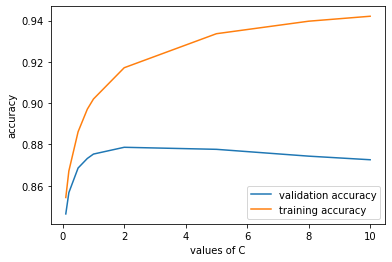

In [35]:
#Simple hypertune
c_values = [10.0, 8.0, 5.0, 2.0, 1.0,0.8,0.5,0.2, 0.1]
#running all specification and comparing their validation accuracy. Note that if liblinear is not worth running with l1,omitted then
results5 = np.zeros((len(c_values),2))
i = 0

for c in c_values:
    begin = time.time()
    logic = LogisticRegression(C=c,max_iter=700,solver = 'newton-cg') #default lbfgs with l2 penalty
    model = make_pipeline(prepro2, logic)
    model.fit(X_train2, y_train2)
    results5[i,0] = model.score(X_val2,y_val2)
    results5[i,1] = model.score(X_train2,y_train2)
    i+=1
    end = time.time()
    print(f'index for c value {c} is {i}, run time {end-begin}')
    
plt.plot(c_values, results5[:,0], label = 'validation accuracy')
plt.plot(c_values, results5[:,1], label = 'training accuracy')
plt.xlabel('values of C')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [63]:
print(np.concatenate((np.array(c_values).reshape(9,1), results5),axis=1))

[[10.          0.8725993   0.9420787 ]
 [ 8.          0.87434222  0.93967875]
 [ 5.          0.87764371  0.93362233]
 [ 2.          0.87863248  0.91714938]
 [ 1.          0.87534775  0.90200415]
 [ 0.8         0.87321937  0.89707441]
 [ 0.5         0.86859393  0.88613432]
 [ 0.2         0.85669516  0.86717765]
 [ 0.1         0.84637171  0.85431928]]


In [ ]:
#Took too long to run
#Simple hypertune
# solvers = ['liblinear','saga']
# penalty = ['l1']
# c_values = [10, 1.0, 0.1,0.01]
# #try l1 penalty
# results4 = np.zeros((8,2))
# i = 0
# for sol in solvers:
#     for c in c_values:
#         for pen in penalty:
#             begin = time.time()
#             logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=500)
#             model = make_pipeline(prepro2, logic)
#             model.fit(X_train2, y_train2)
#             results4[i,0] = model.score(X_val2,y_val2)
#             results4[i,1] = model.score(X_train2,y_train2)
#             i+=1
#             end = time.time()
#             print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
        

In [20]:
#pick best validation accuracy
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=700,C=2.0,solver = 'newton-cg'))

model2.fit(X_train2, y_train2)

predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 91.71493790705954 %
The accuracy of the model in validation set: 87.86324786324786 %


In [21]:
print(model2[1].coef_)
print(model2[1].intercept_)

[[ 1.13062957  0.3185216   0.63804896 ... -0.03424841 -0.03818096
  -0.21093039]]
[-0.90918399]


#### Try convolution network

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from keras.initializers import random_uniform
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

SEED = 42
np.random.seed(SEED)

In [23]:
X_trainConv1 = prepro1.fit_transform(X_train1).toarray()
X_valConv1 = prepro1.fit_transform(X_val1).toarray()
# X_trainConv2 = prepro2.fit_transform(X_train2).toarray()
# X_valConv2 = prepro2.fit_transform(X_val2).toarray()

print(X_trainConv1.shape)
print(X_valConv1.shape)
# print(X_trainConv2.shape)
# print(X_valConv2.shape)

X_trainConv1 = np.reshape(X_trainConv1, (X_trainConv1.shape[0],X_trainConv1.shape[1],1))
X_valConv1 = np.reshape(X_valConv1, (X_valConv1.shape[0],X_valConv1.shape[1],1))
# X_trainConv2 = np.reshape(X_trainConv2, X_trainConv2.shape + (1,))
# X_valConv2 = np.reshape(X_valConv2, X_valConv2.shape + (1,))

print(X_trainConv1.shape)
print(X_valConv1.shape)
# print(X_trainConv2.shape)
# print(X_valConv2.shape)

(238755, 25)
(59670, 25)
(238755, 25, 1)
(59670, 25, 1)


In [24]:
print(y_train1.shape)
print(type(y_train1))

(238755,)
<class 'pandas.core.series.Series'>


In [25]:
dum1 = OneHotEncoder(categories=[['successful','failed']],drop = 'first').fit(y_train1.values.reshape(-1,1))
y_trainConv1 = dum1.transform(y_train1.values.reshape(-1,1)).toarray()
print(y_trainConv1.shape)
dum1 = OneHotEncoder(categories=[['successful','failed']],drop = 'first').fit(y_val1.values.reshape(-1,1))
y_valConv1 = dum1.transform(y_val1.values.reshape(-1,1)).toarray()
print(y_valConv1.shape)

(238755, 1)
(59670, 1)


In [27]:
#SGD does not work
verbose = 1
epochs = 5
batch_size = 512
dropRate = 0.2
nOut = 1
X_train, y_train = X_trainConv1, y_trainConv1

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=4))
model3.add(Flatten())
model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model3.add(Dense(units=nOut, activation='softmax'))
model3.summary()

#when learning rate is about 0.001 to 0.5, the algorithm seems to converge to a local minimum instead of global minimum
optimizer = SGD(lr=0.8) #,momentum=0.0) 
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # fit network
model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 25, 32)            128       
                                                                 
 conv1d_10 (Conv1D)          (None, 25, 16)            1552      
                                                                 
 dropout_3 (Dropout)         (None, 25, 16)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 32)            1568      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                      

In [28]:
_, accuracy = model3.evaluate(X_valConv1, y_valConv1, batch_size=batch_size, verbose=0)
print(accuracy)

0.5949723720550537


In [30]:
verbose = 1
epochs = 20
batch_size = 514
dropRate = 0.2
nOut = 1
X_train, y_train = X_trainConv1, y_trainConv1
hidden_initializer = random_uniform(seed=SEED)

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(dropRate))
model3.add(Flatten())
model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Dense(units=nOut, activation='sigmoid'))
model3.summary()

# optimizer = SGD(lr=0.0001) #,momentum=0.0)
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_valConv1, y_valConv1))
model3.evaluate(X_valConv1, y_valConv1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 25, 32)            128       
                                                                 
 conv1d_16 (Conv1D)          (None, 25, 16)            528       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 12, 16)           0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 12, 32)            1568      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 6, 32)            

[0.23869991302490234, 0.9123177528381348]

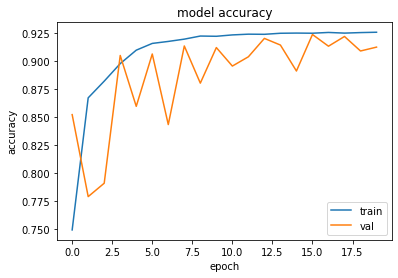

In [32]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'],label = 'val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

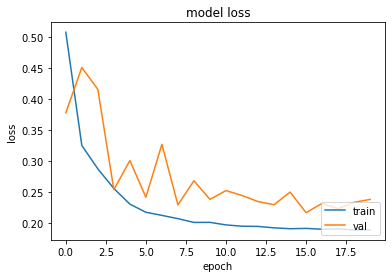

In [33]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

picking 15 epochs should be adequate. We will be using this to hypertune paramters.

Also, try this with different architectures:

In [34]:
print(X_trainConv1.shape)
print(X_valConv1.shape)
X_Conv1 = np.concatenate((X_trainConv1,X_valConv1), axis = 0)
print(X_Conv1.shape)
y_Conv1 = np.concatenate((y_trainConv1,y_valConv1), axis = 0)
print(y_Conv1.shape)

verbose = 0
epochs = 15
batch_size = 514

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

(238755, 25, 1)
(59670, 25, 1)
(298425, 25, 1)
(298425, 1)


In [35]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
results = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



<ipython-input-35-d6d2564322df>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 92.66% (0.18%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.7min finished


In [36]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWithDrop = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWithDrop.mean()*100, resultsWithDrop.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



<ipython-input-36-a005c2c9ee45>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 92.63% (0.27%)
with no Drop: 92.66% (0.18%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 19.8min finished


In [37]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsMoreFilter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsMoreFilter.mean()*100, resultsMoreFilter.std()*100))



<ipython-input-37-e29619bfaf15>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 92.70% (0.38%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.1min finished


In [38]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=8, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsLessFilter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsLessFilter.mean()*100, resultsLessFilter.std()*100))




<ipython-input-38-25a1054f659c>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 91.27% (1.61%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.0min finished


In [39]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWith1Drop = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWith1Drop.mean()*100, resultsWith1Drop.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))




<ipython-input-39-3629d5448b15>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 92.76% (0.17%)
with no Drop: 92.66% (0.18%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.0min finished


In [40]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWith1Dropbix = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWith1Dropbix.mean()*100, resultsWith1Dropbix.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))





<ipython-input-40-81432ff6c8f7>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 92.56% (0.13%)
with no Drop: 92.66% (0.18%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.3min finished


In [41]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsAlter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsAlter.mean()*100, resultsAlter.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


<ipython-input-41-a5f31e027ae8>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 92.46% (0.43%)
with no Drop: 92.66% (0.18%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.8min finished


In [42]:
def create_model(dropRate = 0.2,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsNorm = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsNorm.mean()*100, resultsNorm.std()*100))




<ipython-input-42-9038d97b3fab>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 92.47% (0.35%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 30.6min finished


save files

In [43]:
print(type(results))
print(results.shape)

<class 'numpy.ndarray'>
(10,)


In [44]:
BigResults = np.zeros((8,results.shape[0]))
BigResults[0,:] = results
BigResults[1,:] = resultsWithDrop
BigResults[2,:] = resultsMoreFilter
BigResults[3,:] = resultsLessFilter
BigResults[4,:] = resultsWith1Drop
BigResults[5,:] = resultsWith1Dropbix
BigResults[6,:] = resultsAlter
BigResults[7,:] = resultsNorm
np.save("BigResults.npy", BigResults)

In [46]:
BigResults = np.load("BigResults.npy")
for i in range(8):
    print(f'mean (std) is {BigResults[i,:].mean()*100} ({ BigResults[i,:].std()*100})')

mean (std) is 92.66080260276794 (0.1760264705246045)
mean (std) is 92.6262879371643 (0.27372653687655885)
mean (std) is 92.69967198371887 (0.37505417018514375)
mean (std) is 91.26546621322632 (1.605530242103472)
mean (std) is 92.76267170906067 (0.1729507083744936)
mean (std) is 92.56262063980103 (0.13089832701003906)
mean (std) is 92.46310353279114 (0.4313489790331933)
mean (std) is 92.47181117534637 (0.34982776238670094)


regarding the dropRate

In [47]:
def create_model(dropRate = 0.5,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3
    
estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsDrop05 = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsDrop05.mean()*100, resultsDrop05.std()*100))


<ipython-input-47-8f6427025bbd>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 92.37% (0.48%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.8min finished


In [48]:
def create_model(dropRate = 0.1,nOut = 1):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3
    
estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsDrop01 = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsDrop01.mean()*100, resultsDrop01.std()*100))



<ipython-input-48-2826669a3164>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 92.70% (0.22%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 21.3min finished


Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_321 (Conv1D)         (None, 25, 32)            128       
                                                                 
 conv1d_322 (Conv1D)         (None, 25, 16)            528       
                                                                 
 max_pooling1d_210 (MaxPooli  (None, 12, 16)           0         
 ng1D)                                                           
                                                                 
 conv1d_323 (Conv1D)         (None, 12, 32)            1568      
                                                                 
 max_pooling1d_211 (MaxPooli  (None, 6, 32)            0         
 ng1D)                                                           
                                                                 
 dropout_129 (Dropout)       (None, 6, 32)          

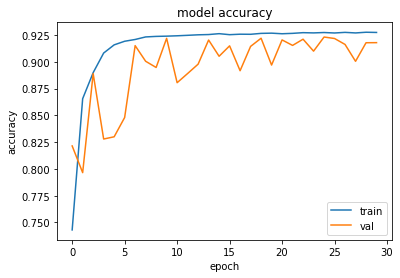

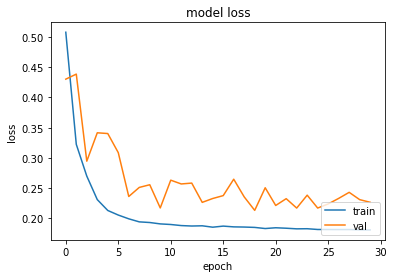

In [50]:
# Final chosen model:
np.random.seed(123)
verbose = 1
epochs = 30
batch_size = 514
dropRate = 0.2
nOut = 1
X_train, y_train = X_trainConv1, y_trainConv1

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(dropRate))
model3.add(Flatten())
model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
# model3.add(Dropout(dropRate))
model3.add(Dense(units=nOut, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_valConv1, y_valConv1))
model3.evaluate(X_valConv1, y_valConv1)

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'],label = 'val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [54]:
print(max(history.history['val_accuracy']))
print(np.argmax(history.history['val_accuracy'])+1)

0.92316073179245
25


In [58]:


model3.fit(X_train, y_train, epochs=25, batch_size=batch_size, verbose=0, validation_data=(X_valConv1, y_valConv1))



#### Try decision tree

In [27]:
model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = 8))

model4.fit(X_train1, y_train1)

predictVal = model4.score(X_val1,y_val1)
predictTrain = model4.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 93.07532826537664 %
The accuracy of the model in validation set: 92.80207809619574 %


In [28]:
model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = 8,min_samples_leaf = 1000))

model4.fit(X_train1, y_train1)

predictVal = model4.score(X_val1,y_val1)
predictTrain = model4.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 92.32309271010031 %
The accuracy of the model in validation set: 92.15015920898274 %


We do not need to try the options randomized trees (random feature chosen, random split) since according to the logistic function, our current amount of features do not overfit (in fact might be underfit) the model. Hence we will be skipping testing these option.

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [29]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i]))
    model4.fit(X_train1, y_train1)
    
    resultsDT[i,0] = model4.score(X_val1,y_val1)
    resultsDT[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT[i,1]*100}%')
    

The accuracy of the model in validation set with depth 1: 84.17797888386124%
The accuracy of the model in training set with depth 1: 84.14190278737618%
The accuracy of the model in validation set with depth 3: 90.55136584548349%
The accuracy of the model in training set with depth 3: 90.4651211492953%
The accuracy of the model in validation set with depth 5: 92.0479302832244%
The accuracy of the model in training set with depth 5: 92.12372515758832%
The accuracy of the model in validation set with depth 7: 92.55572314395843%
The accuracy of the model in training set with depth 7: 92.7980565852024%
The accuracy of the model in validation set with depth 8: 92.80207809619574%
The accuracy of the model in training set with depth 8: 93.07532826537664%
The accuracy of the model in validation set with depth 9: 92.78867102396514%
The accuracy of the model in training set with depth 9: 93.30485225440304%
The accuracy of the model in validation set with depth 10: 92.78364337187867%
The accuracy 

In [30]:
print(resultsDT)

[[0.84177979 0.84141903]
 [0.90551366 0.90465121]
 [0.9204793  0.92123725]
 [0.92555723 0.92798057]
 [0.92802078 0.93075328]
 [0.92788671 0.93304852]
 [0.92783643 0.93593014]
 [0.92713256 0.93910494]
 [0.92518854 0.94292894]
 [0.91861907 0.95762602]
 [0.90745768 0.98205273]]


In [31]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT2 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], criterion='entropy'))
    model4.fit(X_train1, y_train1)
    
    resultsDT2[i,0] = model4.score(X_val1,y_val1)
    resultsDT2[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT2[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT2[i,1]*100}%')
    

The accuracy of the model in validation set with depth 1: 83.51432880844646%
The accuracy of the model in training set with depth 1: 83.51783208728612%
The accuracy of the model in validation set with depth 3: 89.82570806100217%
The accuracy of the model in training set with depth 3: 89.98513120144081%
The accuracy of the model in validation set with depth 5: 91.6155522037875%
The accuracy of the model in training set with depth 5: 91.73546103746519%
The accuracy of the model in validation set with depth 7: 92.47360482654601%
The accuracy of the model in training set with depth 7: 92.64559904504618%
The accuracy of the model in validation set with depth 8: 92.75012569130216%
The accuracy of the model in training set with depth 8: 92.93669242528952%
The accuracy of the model in validation set with depth 9: 92.76018099547511%
The accuracy of the model in training set with depth 9: 93.12265711712844%
The accuracy of the model in validation set with depth 10: 92.81883693648399%
The accurac

In [32]:
print(resultsDT2)

[[0.83514329 0.83517832]
 [0.89825708 0.89985131]
 [0.91615552 0.91735461]
 [0.92473605 0.92645599]
 [0.92750126 0.92936692]
 [0.92760181 0.93122657]
 [0.92818837 0.93366003]
 [0.92786995 0.93639086]
 [0.9268309  0.93920965]
 [0.92059661 0.95127222]
 [0.90946874 0.97390212]]


In [33]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT3 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], min_samples_leaf=1000))
    model4.fit(X_train1, y_train1)
    
    resultsDT3[i,0] = model4.score(X_val1,y_val1)
    resultsDT3[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT3[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT3[i,1]*100}%')

The accuracy of the model in validation set with depth 1: 84.17797888386124%
The accuracy of the model in training set with depth 1: 84.14190278737618%
The accuracy of the model in validation set with depth 3: 90.55136584548349%
The accuracy of the model in training set with depth 3: 90.4651211492953%
The accuracy of the model in validation set with depth 5: 91.96246019775431%
The accuracy of the model in training set with depth 5: 92.03199932985696%
The accuracy of the model in validation set with depth 7: 92.15015920898274%
The accuracy of the model in training set with depth 7: 92.32309271010031%
The accuracy of the model in validation set with depth 8: 92.15015920898274%
The accuracy of the model in training set with depth 8: 92.32309271010031%
The accuracy of the model in validation set with depth 9: 92.15015920898274%
The accuracy of the model in training set with depth 9: 92.32309271010031%
The accuracy of the model in validation set with depth 10: 92.15015920898274%
The accurac

In [34]:
print(resultsDT3)

[[0.84177979 0.84141903]
 [0.90551366 0.90465121]
 [0.9196246  0.92031999]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]
 [0.92150159 0.92323093]]


In [35]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT4 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], min_samples_leaf=40))
    model4.fit(X_train1, y_train1)
    
    resultsDT4[i,0] = model4.score(X_val1,y_val1)
    resultsDT4[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT4[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT4[i,1]*100}%')

The accuracy of the model in validation set with depth 1: 84.17797888386124%
The accuracy of the model in training set with depth 1: 84.14190278737618%
The accuracy of the model in validation set with depth 3: 90.55136584548349%
The accuracy of the model in training set with depth 3: 90.4651211492953%
The accuracy of the model in validation set with depth 5: 92.0479302832244%
The accuracy of the model in training set with depth 5: 92.12372515758832%
The accuracy of the model in validation set with depth 7: 92.53728841964136%
The accuracy of the model in training set with depth 7: 92.78591024271743%
The accuracy of the model in validation set with depth 8: 92.78364337187867%
The accuracy of the model in training set with depth 8: 93.02758057422881%
The accuracy of the model in validation set with depth 9: 92.78029160382101%
The accuracy of the model in training set with depth 9: 93.16160918095956%
The accuracy of the model in validation set with depth 10: 92.81380928439752%
The accuracy

In [36]:
print(resultsDT4)

[[0.84177979 0.84141903]
 [0.90551366 0.90465121]
 [0.9204793  0.92123725]
 [0.92537288 0.9278591 ]
 [0.92783643 0.93027581]
 [0.92780292 0.93161609]
 [0.92813809 0.93261293]
 [0.92845651 0.93336684]
 [0.92857382 0.93364327]
 [0.92835596 0.93425478]
 [0.92832244 0.93438881]]


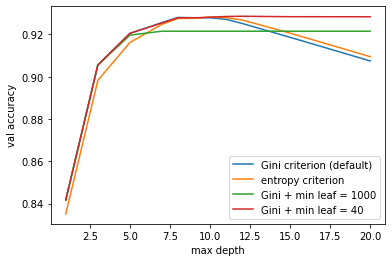

the highest validation accuracy for Gini default is 0.9280207809619574 at depth 8
the highest validation accuracy for entropy is 0.92818836936484 at depth 10
the highest validation accuracy for Gini min leaf 1000 is 0.9215015920898274 at depth 7
the highest validation accuracy for Gini min leaf 40 is 0.9285738226914697 at depth 12


In [37]:
plt.plot(max_depth, resultsDT[:,0], label='Gini criterion (default)')
plt.plot(max_depth, resultsDT2[:,0], label='entropy criterion')
plt.plot(max_depth, resultsDT3[:,0], label='Gini + min leaf = 1000')
plt.plot(max_depth, resultsDT4[:,0], label='Gini + min leaf = 40')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('val accuracy')
plt.show()
print(f'the highest validation accuracy for Gini default is {np.max(resultsDT[:,0])} at depth {max_depth[np.argmax(resultsDT[:,0])]}')
print(f'the highest validation accuracy for entropy is {np.max(resultsDT2[:,0])} at depth {max_depth[np.argmax(resultsDT2[:,0])]}')
print(f'the highest validation accuracy for Gini min leaf 1000 is {np.max(resultsDT3[:,0])} at depth {max_depth[np.argmax(resultsDT3[:,0])]}')
print(f'the highest validation accuracy for Gini min leaf 40 is {np.max(resultsDT4[:,0])} at depth {max_depth[np.argmax(resultsDT4[:,0])]}')


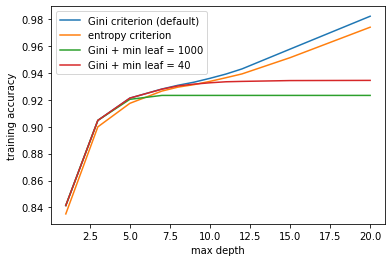

the highest training accuracy for Gini default is 0.9820527318799607 at depth 20
the highest training accuracy for entropy is 0.9739021172331469 at depth 20
the highest training accuracy for Gini min leaf 1000 is 0.9232309271010031 at depth 7
the highest training accuracy for Gini min leaf 40 is 0.934388808611338 at depth 20


In [38]:
plt.plot(max_depth, resultsDT[:,1], label='Gini criterion (default)')
plt.plot(max_depth, resultsDT2[:,1], label='entropy criterion')
plt.plot(max_depth, resultsDT3[:,1], label='Gini + min leaf = 1000')
plt.plot(max_depth, resultsDT4[:,1], label='Gini + min leaf = 40')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('training accuracy')
plt.show()
print(f'the highest training accuracy for Gini default is {np.max(resultsDT[:,1])} at depth {max_depth[np.argmax(resultsDT[:,1])]}')
print(f'the highest training accuracy for entropy is {np.max(resultsDT2[:,1])} at depth {max_depth[np.argmax(resultsDT2[:,1])]}')
print(f'the highest training accuracy for Gini min leaf 1000 is {np.max(resultsDT3[:,1])} at depth {max_depth[np.argmax(resultsDT3[:,1])]}')
print(f'the highest training accuracy for Gini min leaf 40 is {np.max(resultsDT4[:,1])} at depth {max_depth[np.argmax(resultsDT4[:,1])]}')


In [40]:
model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = 12, min_samples_leaf=40))
model4.fit(X_train1, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[['Film '
                                                                             '& '
                                                                             'Video',
                                                                             'Music',
                                                                             'Publishing',
                                                                             'Games',
                                                                             'Technology',
                                                                             'Art',
                                                                             'Design',
                                                                             'Food',
                                

In [42]:
from sklearn import tree

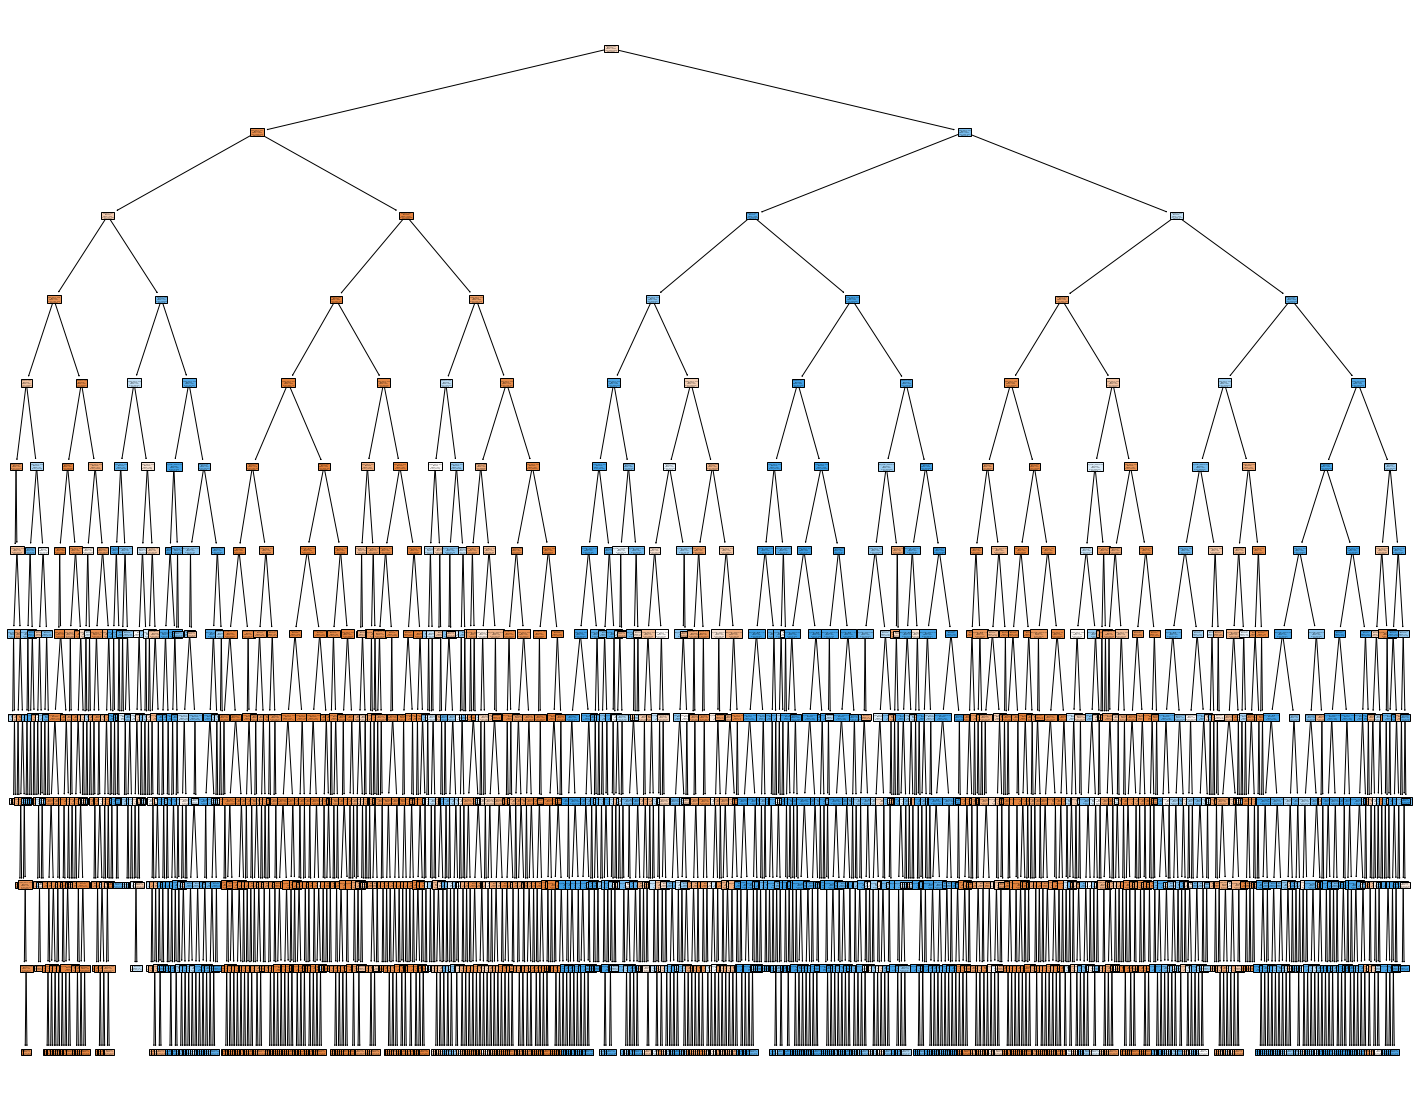

In [43]:
X = prepro1.fit_transform(X_train1)
y = y_train1
clf = DecisionTreeClassifier(max_depth = 12, min_samples_leaf=40)
res = clf.fit(X, y)


enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')
dum = enc1.fit_transform(X_train1[['main_category','currency']])
listFeat = enc1.get_feature_names(['main_category','currency']).tolist()
listContFeat = ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']
for i in listContFeat:
    listFeat.append(i)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=listFeat,
                  class_names=['success','failed'],
                  filled=True)

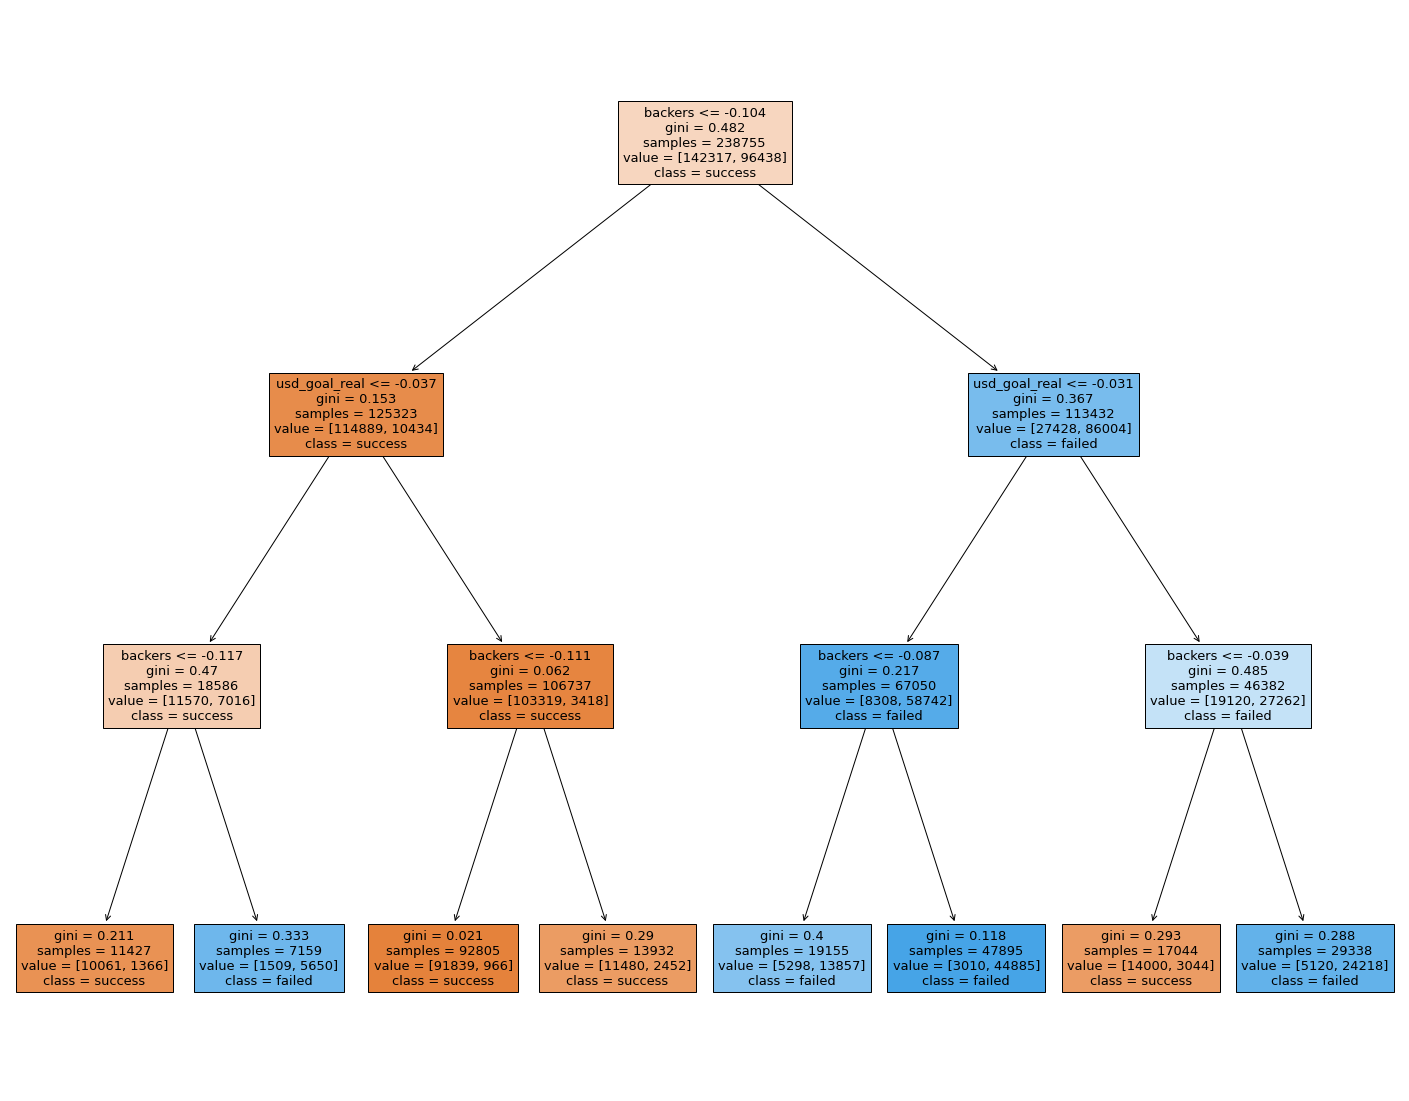

In [41]:
X = prepro1.fit_transform(X_train1)
y = y_train1
clf = DecisionTreeClassifier(max_depth = 3)
res = clf.fit(X, y)


enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')
dum = enc1.fit_transform(X_train1[['main_category','currency']])
listFeat = enc1.get_feature_names(['main_category','currency']).tolist()
listContFeat = ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']
for i in listContFeat:
    listFeat.append(i)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=listFeat,
                  class_names=['success','failed'],
                  filled=True)

### Second case: multi-category regression (In the second notebook)

## Test results

In [48]:
#df1 has all the thing needed for this part
dfS_test = df_test.copy()
dfS_test = dfS_test[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_test = dfS_test[(dfS_test['state'] == 'successful') | (dfS_test['state'] == 'failed')]
dfS_test.shape



(33247, 10)

In [49]:
X_test1 = dfS_test.drop(columns=['state','name'])
y_test1 = dfS_test['state']
X_test2 = dfS_test.drop(columns=['state'])
y_test2 = dfS_test['state']

In [50]:
print(f'Test result for logistic without text feature = {model1.score(X_test1,y_test1)*100}')
print(f'Test result for logistic with text feature = {model2.score(X_test2,y_test2)*100}')
print(f'Test result for logistic with decision tree = {model4.score(X_test1,y_test1)*100}')

Test result for logistic without text feature = 82.35630282431498
Test result for logistic with text feature = 87.82145757511955
Test result for logistic with decision tree = 82.5518091857912


In [59]:
X_testConv1 = prepro1.fit_transform(X_test1).toarray()
X_testConv1 = np.reshape(X_testConv1, (X_testConv1.shape[0],X_testConv1.shape[1],1))

dum1 = OneHotEncoder(categories=[['successful','failed']], drop="first").fit(y_test1.values.reshape(-1,1))
y_testConv1 = dum1.transform(y_test1.values.reshape(-1,1)).toarray()

print(f'Test result for logistic with convolution network = {model3.evaluate(X_testConv1,y_testConv1)}')



1039/1039 [==============================] - 2s 2ms/step - loss: 0.7553 - accuracy: 0.8424
Test result for logistic with convolution network = [0.7553448677062988, 0.8423616886138916]
